# Kaggle - New York City Taxi Fare Prediction
## Data Set
[Kaggle - NY City Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data)  
[참고 노트북 | Fare prediction: Stacked ensemble XGBoost & LGBM](https://www.kaggle.com/code/amar09/fare-prediction-stacked-ensemble-xgboost-lgbm/notebook)

## 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import glob
import warnings
warnings.filterwarnings("ignore")


c:\Users\spec3\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def reg_score(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    MAE = np.mean( np.abs((y_true - y_pred) / y_true) )
    NMAE =mean_absolute_error(y_true, y_pred)/ np.mean( np.abs(y_true) )
    MAPE = np.mean( np.abs((y_true - y_pred) / y_true) ) *100
    R2 = r2_score(y_true, y_pred)
    
    print(f"MSE: {np.round(MSE, 3)}\nRMSE: {np.round(RMSE, 3)}\nMAE: {np.round(MAE, 3)}\nNMAE: {np.round(NMAE, 3)}\nMAPE: {np.round(MAPE, 3)}\nR2: {np.round(R2, 3)}")


## Data Load

In [3]:
path = glob.glob("data/*")
path

['data\\GCP-Coupons-Instructions.rtf',
 'data\\sample_submission.csv',
 'data\\test.csv',
 'data\\train.csv']

In [4]:
train, test = pd.read_csv(path[3]), pd.read_csv(path[2])

train.shape, test.shape

((55423856, 8), (9914, 7))

`train` 데이터의 경우, 5500만개가 넘으므로 일부만 사용할 예정  
이상치를 최대한 억제하기 위해, 일부 조건을 걸고 크기를 다시 봄

In [5]:
# 뉴욕 택시 기본 요금
cond1 = train["fare_amount"]>=2.5
cond2 = train["passenger_count"]>=1
# 뉴욕 경계 좌표
# -74.27 ~ -73.68
cond3 = (train["pickup_longitude"]>=-74.27) & (train["pickup_longitude"]<=-73.68)
# 40.92 ~ 40.49
cond4 = (train["pickup_latitude"]>=40.49) & (train["pickup_latitude"]<=40.92)

# 뉴욕 내부에서 출발했고, 1명 이상의 승객이 기본 요금 이상을 지불한 경우
cond = cond1 & cond2 & cond3 & cond4

In [6]:
train = train[cond].copy()
train.shape

(54076513, 8)

약 130만행 정도가 사라졌음  
이중 랜덤으로 200만행 정도만 샘플링해 사용하겠음


In [7]:
train = train.sample(2000000).reset_index(drop=True)
display(train.shape)
display(train.head(3))
display(train.tail(3))

(2000000, 8)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-06-12 07:31:07.0000004,8.5,2015-06-12 07:31:07 UTC,-73.983932,40.746296,-73.971291,40.764271,1
1,2014-04-01 17:42:27.0000003,11.5,2014-04-01 17:42:27 UTC,-73.971185,40.761795,-73.990818,40.755135,1
2,2012-08-12 21:44:24.0000001,21.3,2012-08-12 21:44:24 UTC,-74.011484,40.703160,-73.923391,40.753506,1


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1999997,2012-08-08 09:23:00.00000095,8.1,2012-08-08 09:23:00 UTC,-73.954045,40.767180,-73.969502,40.754222,1
1999998,2014-09-26 09:32:00.0000006,7.0,2014-09-26 09:32:00 UTC,-73.963013,40.766502,-73.958853,40.780897,1
1999999,2013-01-26 13:54:08.0000005,7.5,2013-01-26 13:54:08 UTC,-73.983236,40.730578,-73.992465,40.742688,1


## EDA 및 전처리

### 기본 정보

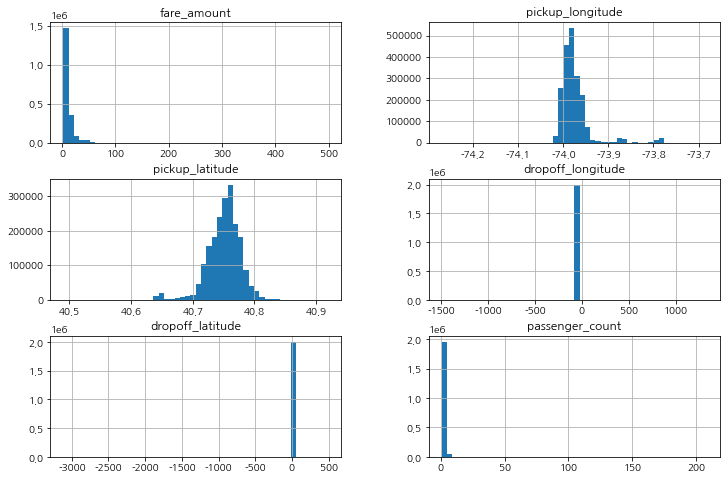

In [9]:
_ = train.hist(bins=50, figsize=(12, 8))

In [10]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,1.132335e+01,-7.397544e+01,4.075083e+01,-7.391416e+01,4.071818e+01,1.692157e+00
std,9.647562e+00,3.459587e-02,2.692279e-02,3.594479e+00,3.306081e+00,1.316041e+00
min,2.500000e+00,-7.426906e+01,4.049036e+01,-1.491201e+03,-3.114278e+03,1.000000e+00
25%,6.000000e+00,-7.399227e+01,4.073656e+01,-7.399157e+01,4.073556e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075335e+01,-7.398059e+01,4.075380e+01,1.000000e+00
75%,1.250000e+01,-7.396833e+01,4.076754e+01,-7.396527e+01,4.076837e+01,2.000000e+00
max,4.990000e+02,-7.368230e+01,4.091934e+01,1.328726e+03,4.940167e+02,2.080000e+02


### 결측치 확인

In [11]:
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [12]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### 파생 변수 생성
#### Date Time

In [13]:
train["key"] = pd.to_datetime(train["key"])
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])

test["key"] = pd.to_datetime(test["key"])
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])

In [14]:
data = [train,test]
for _ in data:
    _['Year'] = _['pickup_datetime'].dt.year
    _['Month'] = _['pickup_datetime'].dt.month
    _['Date'] = _['pickup_datetime'].dt.day
    _['Day of Week'] = _['pickup_datetime'].dt.dayofweek
    _['Hour'] = _['pickup_datetime'].dt.hour

### Harversine Formula
위경도 좌표 사이의 거리를 구할 때 사용하는 공식  

$ haversine(θ) = sin²{θ \over 2} $  

a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)  
c = 2 * atan2( √a, √(1−a) )  
d = R ⋅ c  
d = Haversine distance

In [15]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for _ in data:
        R = 6371 # km, 지구의 반지름
        phi1 = np.radians(_[lat1])
        phi2 = np.radians(_[lat2])
        
        delta_phi = np.radians(_[lat2]-_[lat1])
        delta_lambda = np.radians(_[long2]-_[long2])
        
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = (R * c)
        _["H_Distance"] = d

In [16]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

#### 불필요한 컬럼 제거

In [17]:
del_col = ["key", "pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

In [18]:
print(f"{train.shape} | {test.shape}")
train.drop(columns=del_col, inplace=True)
test.drop(columns=del_col, inplace=True)
print(f"{train.shape} | {test.shape}")

(2000000, 14) | (9914, 13)
(2000000, 8) | (9914, 7)


### 추가 EDA 및 시각화

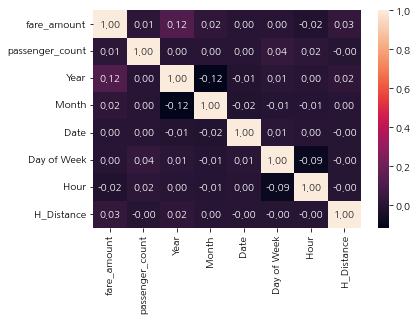

In [20]:
corr = train.corr()
_ = sns.heatmap(corr, annot=True, fmt=".2f")

In [21]:
train.head()

,fare_amount,passenger_count,Year,Month,Date,Day of Week,Hour,H_Distance
0,8.5,1,2015,6,12,4,7,1.998713
1,11.5,1,2014,4,1,1,17,0.740558
2,21.3,1,2012,8,12,6,21,5.598220
3,5.3,1,2009,10,16,4,7,1.249386
4,36.5,5,2011,6,29,2,22,10.995066


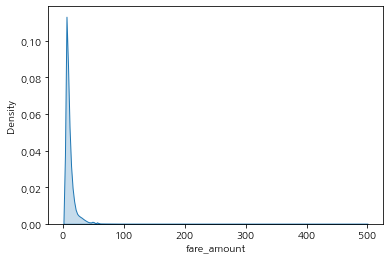

In [25]:
_ = sns.kdeplot(data=train, x="fare_amount", shade=True)

`fare_amount`가 한쪽으로 치우쳐 있으므로, log scale을 적용

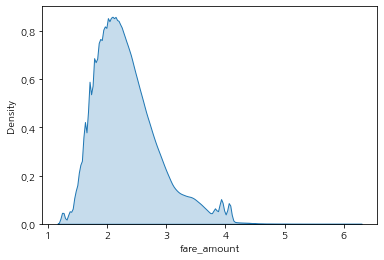

In [26]:
train["fare_amount"] = np.log1p(train["fare_amount"])
_ = sns.kdeplot(data=train, x="fare_amount", shade=True)

## Train
별다른 튜닝 없이 기본 모델만 사용

### Data Split

In [29]:
label = "fare_amount"
features = train.columns.tolist()
features.remove(label)

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[label], test_size=0.2)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_valid: {X_valid.shape}\ny_valid: {y_valid.shape}")

X_train: (1600000, 7)
y_train: (1600000,)
X_valid: (400000, 7)
y_valid: (400000,)


### Random Forest

In [32]:
reg_rf = RandomForestRegressor()

pred_reg_rf = reg_rf.fit(X_train, y_train).predict(X_valid)

reg_score(y_valid, pred_reg_rf)

MSE: 0.145
RMSE: 0.38
MAE: 0.118
NMAE: 0.115
MAPE: 11.839
R2: 0.514


### XGBoost

In [33]:
reg_xgb = XGBRegressor(learning_rate=0.3)

pred_reg_xgb = reg_xgb.fit(X_train, y_train).predict(X_valid)

reg_score(y_valid, pred_reg_xgb)

MSE: 0.133
RMSE: 0.365
MAE: 0.11
NMAE: 0.108
MAPE: 10.998
R2: 0.553


### LGBM

In [34]:
reg_lgbm = LGBMRegressor(learning_rate=0.3)

pred_reg_lgbm = reg_lgbm.fit(X_train, y_train).predict(X_valid)

reg_score(y_valid, pred_reg_lgbm)

MSE: 0.135
RMSE: 0.367
MAE: 0.11
NMAE: 0.109
MAPE: 11.047
R2: 0.548


### Stacking
XGBoost와 LGBM을 이용한 스택킹 모델  
각각의 예측값에 가중치를 주는 방식으로 구성됨

In [40]:
stack_pred = (0.5*pred_reg_xgb) + (0.5*pred_reg_lgbm)

reg_score(y_valid, stack_pred)

MSE: 0.133
RMSE: 0.365
MAE: 0.11
NMAE: 0.108
MAPE: 11.007
R2: 0.553


#### 제출

In [43]:
sub = pd.read_csv(path[1])
sub.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [46]:
# XGB
sub["fare_amount"] = np.expm1(reg_xgb.predict(test))
sub.to_csv("data/sub_xgb_rmse_365.csv", index=False)

In [47]:
# lgbm
sub["fare_amount"] = np.expm1(reg_lgbm.predict(test))
sub.to_csv("data/sub_lgbm_rmse_367.csv", index=False)

In [48]:
# stacking
sub["fare_amount"] = (0.5*np.expm1(reg_xgb.predict(test))) + (0.5*np.expm1(reg_lgbm.predict(test)))
sub.to_csv("data/sub_stack_rmse_365.csv", index=False)

Kaggle 제출 점수가 처참한걸보면, train시 사용한 feature가 너무 적은거 같다